# 2. Ridge regression

Realicemos una predicción basada en una estimación de un modelo de regresión lineal por mínimos cuadrados.
Se parte de los datos analizados, normalizados y acotados logrados en el punto 0, para el training.

Este método se utiliza cuando el data set presenta multicolinearidad (hay correlación entre las variables predictoras). Tras el punto 0, anaálisis de datos, ya vimos que si existía, por lo que puede ser un buen método para este data set.

Partiendo de una contrucción del modelo, haremos un proceso iterativo de validación y ajuste del mismo (modificando parámetros y variables), hasta obtener el que mejor predice nuestra target, sin infra o sobreajustes

## Importación de datos y selección de variables


In [4]:
#Librerías a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.linear_model import Ridge
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score

from scipy.stats import skew

import seaborn as sns
%matplotlib inline



#Importación de datos
df_train = pd.read_csv("data/PreciosCasas/train_final.csv", sep='\t', encoding='utf-8') 
df_test = pd.read_csv("data/PreciosCasas/test.csv") 

# print a summary of the data in Melbourne data
df_train.describe()

,Unnamed: 0,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,...,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000
mean,728.805765,729.805765,56.877145,10460.434454,6.094715,5.576527,1971.194235,1984.818806,439.128346,46.645161,...,0.003432,0.082361,0.002059,0.868909,0.069321,0.002745,0.008236,0.013727,0.821551,0.084420
std,421.402158,421.402158,42.339638,9862.564977,1.376542,1.113638,30.190353,20.640669,432.964939,161.471529,...,0.058500,0.275008,0.045345,0.337616,0.254086,0.052342,0.090410,0.116395,0.383022,0.278112
min,0.000000,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,364.000000,365.000000,20.000000,7540.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,729.000000,730.000000,50.000000,9473.000000,6.000000,5.000000,1972.000000,1994.000000,383.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1093.000000,1094.000000,70.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,712.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1459.000000,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,2188.000000,1474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [11]:
#Verificamos que el data set de test es correcto
df_test_dummies = df_test.select_dtypes(include = ['object'])
df_test = df_test.select_dtypes(exclude = ['object'])

df_test_dummies = pd.get_dummies(df_test_dummies)

ValueError: No objects to concatenate

In [18]:
#Vamos a ver que variables elegimos: todas como columnas y el SalesPrice como target

X= df_train.ix[:, df_train.columns != 'Unnamed: 0']
X= X.ix[:, X.columns != 'SalePrice']
X= X.ix[:, X.columns != 'Id']

print (X.head())

y= df_train['SalePrice']


   MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0          60     8450            7            5       2003          2003   
1          20     9600            6            8       1976          1976   
2          60    11250            7            5       2001          2002   
3          70     9550            7            5       1915          1970   
4          60    14260            8            5       2000          2000   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF          ...            \
0         706           0        150          856          ...             
1         978           0        284         1262          ...             
2         486           0        434          920          ...             
3         216           0        540          756          ...             
4         655           0        490         1145          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0 

/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/root/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


Queremos prededir el precio, será nuestro target, para lo cual, cogeremos el resto de variables como pedictores 

In [14]:
X.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,...,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000,1457.000000
mean,729.805765,56.877145,10460.434454,6.094715,5.576527,1971.194235,1984.818806,439.128346,46.645161,567.222375,...,0.003432,0.082361,0.002059,0.868909,0.069321,0.002745,0.008236,0.013727,0.821551,0.084420
std,421.402158,42.339638,9862.564977,1.376542,1.113638,30.190353,20.640669,432.964939,161.471529,442.212926,...,0.058500,0.275008,0.045345,0.337616,0.254086,0.052342,0.090410,0.116395,0.383022,0.278112
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.000000,20.000000,7540.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,730.000000,50.000000,9473.000000,6.000000,5.000000,1972.000000,1994.000000,383.000000,0.000000,479.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1094.000000,70.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,712.000000,0.000000,808.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,2188.000000,1474.000000,2336.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Implementación de los parámetros del modelo usando Cross validation

El modelo que vamos a hacer es un ridge regression, intentaremos mejorara los parámetros de alpha y solver, y luego validamos cual es la mejor combiación mediante la evalución de la RMSE.

Para ser capaces de ir validando el modelo, lo separaremos en dos grupos, predictors and target. Lo haremos mediando un split con un número generaro aleatorio. Como queremos que todas las veces que ejecutemos el modelo nos salga lo mismo, estableceremos el argumento de random_state.

In [16]:
from sklearn.model_selection import train_test_split

#Separamos los datos en dos grupos, 
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)


In [19]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
solvers = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']

cv_score = []
for i in solvers:
    for ii in alphas:
        clf = Ridge(alpha = ii, solver = i)
        cv_score.append(np.sqrt(-cross_val_score(estimator=clf, 
                                            X=X, 
                                            y=y, 
                                            cv=15, 
                                            scoring = "neg_mean_squared_error")).mean())

,svd,cholesky,lsqr,sparse_cg,sag,alpha
0,0.117436,0.117436,0.15992,0.15992,0.203924,0.05
1,0.117051,0.117051,0.15992,0.15992,0.203935,0.10
2,0.115871,0.115871,0.15992,0.15992,0.203930,0.30
3,0.113742,0.113742,0.15992,0.15992,0.203930,1.00
4,0.111950,0.111950,0.15992,0.15992,0.203930,3.00
5,0.111535,0.111535,0.15992,0.15992,0.203921,5.00
6,0.111530,0.111530,0.15992,0.15992,0.203929,10.00
7,0.111806,0.111806,0.15992,0.15992,0.203925,15.00
8,0.112715,0.112715,0.15992,0.15992,0.203929,30.00
9,0.113761,0.113761,0.15992,0.15992,0.203926,50.00


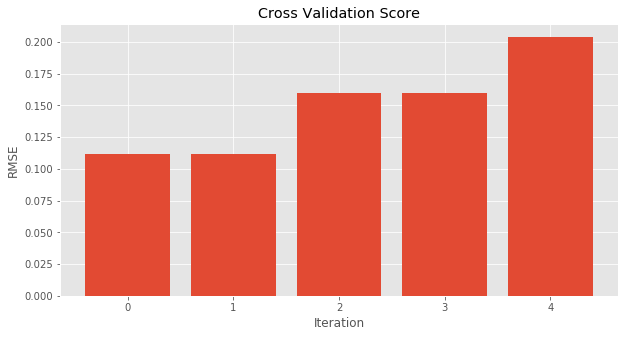

In [20]:
# Veamos los resultados de la comparación

cv_score = np.reshape(cv_score, (5,11))
score = pd.DataFrame(cv_score).T
score.columns = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
score['alpha'] = alphas
score.set_index(['alpha'])

plt.figure(figsize=(10,5))
plt.bar(range(len(score[score.columns[:-1]].min().values)), score[score.columns[:-1]].min().values)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')


score

Veamos como de bien se ajusta el modelo ( comparación de la predicción con la target)

RMSE Score: 0.11180647654844066


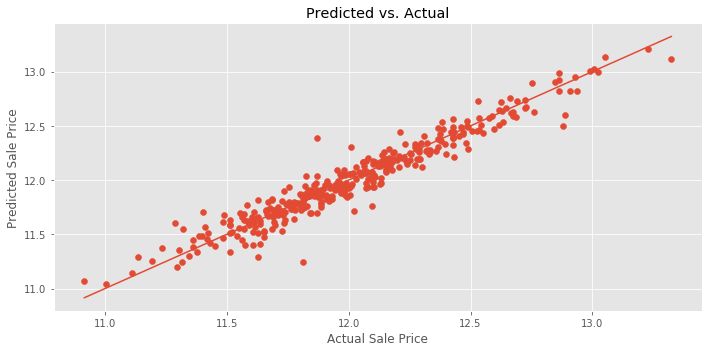

In [24]:
clf = Ridge(alpha = 15)
clf.fit(train_X, train_y)
y_pred = clf.predict(val_X)

plt.figure(figsize=(10, 5))
plt.scatter(val_y, y_pred)
plt.plot([min(val_y), max(val_y)], [min(val_y), max(val_y)])
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.tight_layout()


cv_score = np.sqrt(-cross_val_score(clf, 
                                    X, 
                                    y, 
                                    cv=15, 
                                    scoring = "neg_mean_squared_error"))

print("RMSE Score: {}".format(cv_score.mean()))

## Mejora del modelo

En este punto lo optimo es analizar la importancia o peso relativo de cada variable en el proceso. Representemoslo

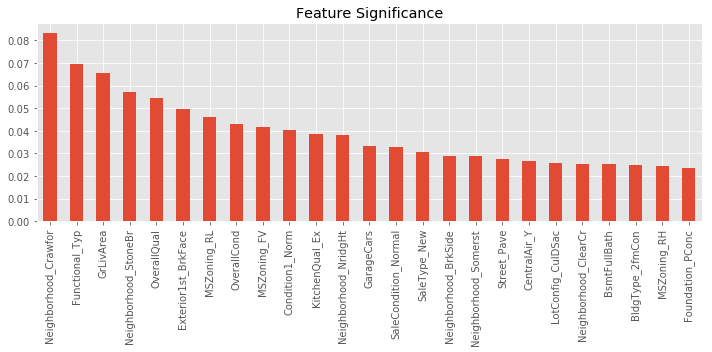

In [26]:
# Fit model with training data
clf.fit(X, y)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.coef_ , index = X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()